In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model

Populating the interactive namespace from numpy and matplotlib


C:\Users\Almaz\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['trapz']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


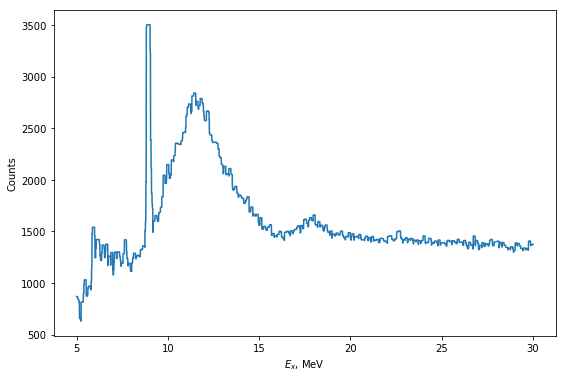

In [2]:
Ga_5_28 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/5_28.csv', 
                      sep='\t', decimal=',')

plt.figure(figsize=(9,6))
plt.plot(Ga_5_28['x'].values, Ga_5_28['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
#plt.ylim(0,6)

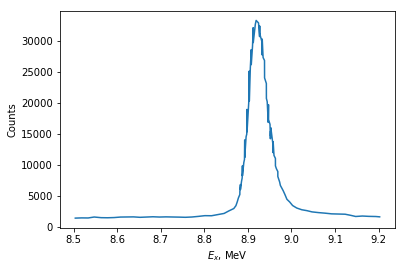

In [3]:
IAS = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/IAS.csv', 
                      sep='\t', decimal=',')
IAS['y'] = IAS['y'] * 1000
plt.plot(IAS['x'].values, IAS['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
#plt.xlim(8.9,9)

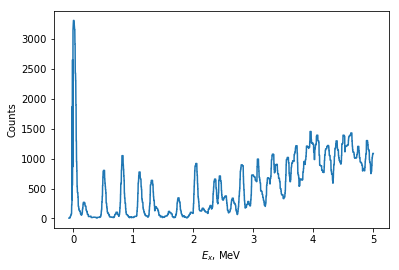

In [4]:
Ga_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/0_5.csv', 
                      sep='\t', decimal=',')
plt.plot(Ga_0_5['x'].values, Ga_0_5['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')

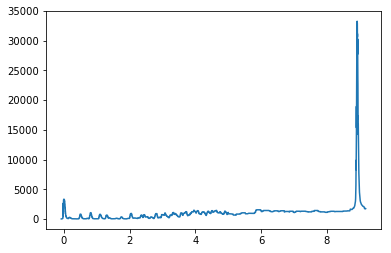

In [5]:
beginning = Ga_5_28[((Ga_5_28['x']<8.7))]
middle = IAS[((IAS['x']>8.7) & (IAS['x']<9.18))]
#ending = Ga_5_28[((Ga_5_28['x']>9.18) & (Ga_5_28['x']<9.5))]
ending = Ga_5_28[((Ga_5_28['x']>9.18))]

#data = Ga_0_5.append(beginning).append(middle).append(ending)
data = Ga_0_5.append(beginning).append(middle)

plt.plot(data['x'].values, data['y'].values)

(0, 20)

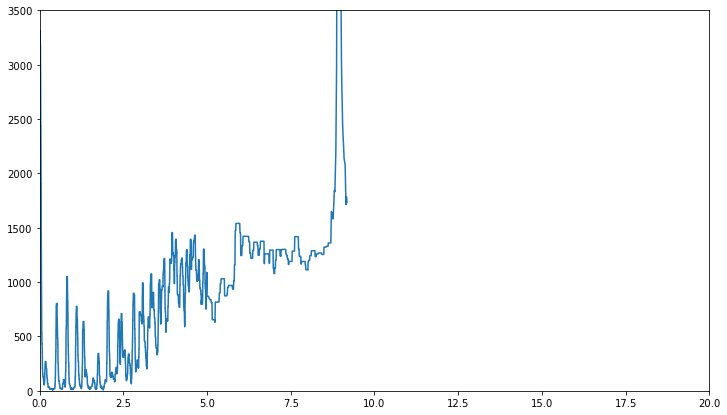

In [6]:
plt.figure(figsize=(12,7))
plt.plot(data['x'].values, data['y'].values)
plt.ylim(0,3500)
plt.xlim(0,20)

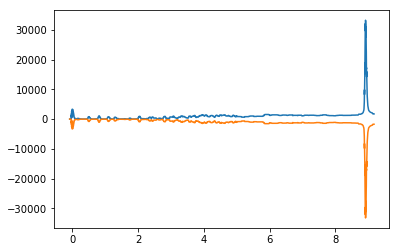

In [7]:
plt.plot(data['x'].values, data['y'].values)
plt.plot(data['x'].values, -data['y'].values)

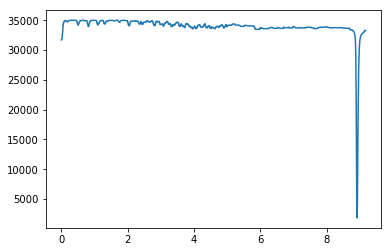

In [8]:
x_data = np.linspace(0,9.18,len(data['x'].values))
y_data = np.interp(x_data, data['x'].values, data['y'].values)
#plt.plot(x_data, y_data)
plt.plot(x_data, -y_data+35000)

(0, 5000)

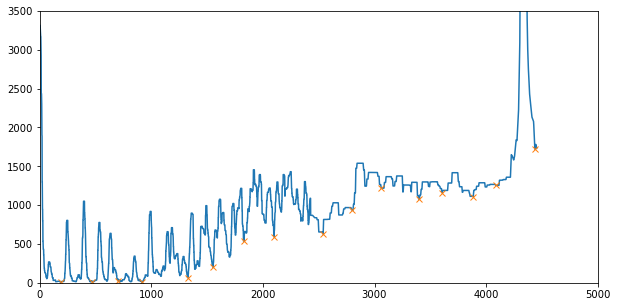

In [9]:
peaks, _ = sc.signal.find_peaks(-y_data+35000, distance=201)
plt.figure(figsize=(10,5))
plt.plot(y_data)
plt.plot(peaks, y_data[peaks], "x")
plt.ylim(0,3500)
plt.xlim(0,5000)

(8.7, 9.2)

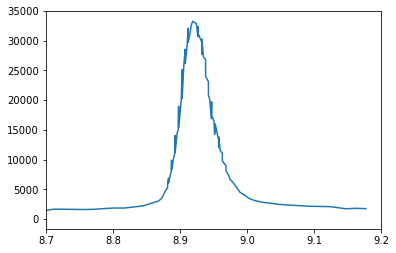

In [10]:
plt.plot(data['x'].values, data['y'].values)
plt.xlim(8.7,9.2)

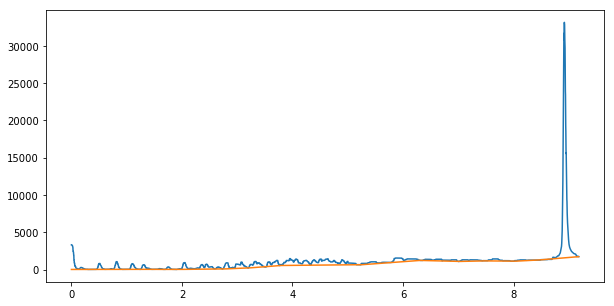

In [11]:
y_data2 = np.interp(x_data, x_data[peaks], y_data[peaks])
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data)
plt.plot(x_data, y_data2)
#plt.xlim(8.5,9.2)

(0, 3.5)

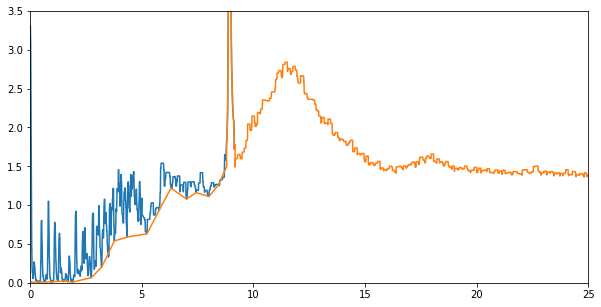

In [12]:
temp1 = pd.DataFrame({'x':x_data, 'y':y_data})
temp2 = pd.DataFrame({'x':x_data, 'y':y_data2})

data3 = temp2[(temp2['x']<8.8)].append(temp1[((temp1['x']>8.8) & (temp1['x']<9.18))]).append(ending)
data4 = Ga_0_5.append(beginning).append(middle).append(ending)


temp1['y'] = temp1['y'] / 1000
temp2['y'] = temp2['y'] / 1000
data3['y'] = data3['y'] / 1000
data4['y'] = data4['y'] / 1000

plt.figure(figsize=(10,5))
plt.plot(temp1['x'].values, temp1['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(data4['x'].values, data4['y'].values, ls='--')
plt.xlim(0,25)
plt.ylim(0,3.5)

In [13]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [14]:
def QFC_back3(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

def QFC_back4(x, E_qf, N_0):
    W = 22
    T = 100
    Q_EC_71Ge=0.232
    S_p_71Ge=8.285
    E_t_gs = 420 - Q_EC_71Ge
    E_0 = E_t_gs - S_p_71Ge
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [17]:
#np.random.seed(150)

total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(breit_vigner3, prefix='T1_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back4, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=4.5, min=3, max=5)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=3)
total_mod.set_param_hint('pigmy1_M', value=5, min=0.1, max=5)

total_mod.set_param_hint('pigmy2_w', value=6, min=4, max=8)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy2_M', value=1, min=0.1, max=5)

total_mod.set_param_hint('IAS1_w', value=8.913, min=8.8, max=9.1) #возможно ошибка в оцифровке, если фиксировать значение, то пик получается смещенным
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.04)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=5)

total_mod.set_param_hint('GTR_w', value=11.75, min=11, max=13)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 10)

total_mod.set_param_hint('T1_w', value=18, min=17.8, max=18.2)
total_mod.set_param_hint('T1_G1', value=1, min=0.1, max=1)
total_mod.set_param_hint('T1_M', value=0.5, min=0.1, max=3)

total_mod.set_param_hint('SDR_w', value=22, min=18, max=30)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=8)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max=0.5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, min=1, max=15 )

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='T1_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back4, prefix='QFC_back_'))
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 37911
    # data points      = 7197
    # variables        = 20
    chi-square         = 304.535665
    reduced chi-square = 0.04243217
    Akaike info crit   = -22721.4578
    Bayesian info crit = -22583.8294
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this.  Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    pigmy1_M:       0.11568269 (init = 5)
    pigmy1_w:       4.18056403 (init = 4.5)
    pigmy1_G1:      0.

(0, 3.5)

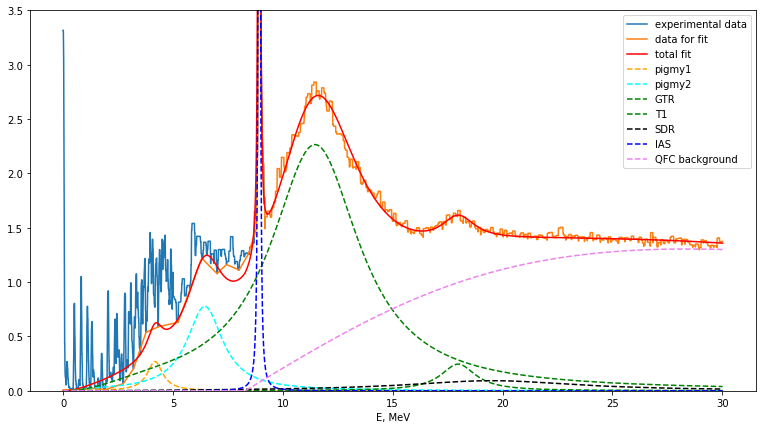

In [18]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(temp1['x'].values, temp1['y'].values, label='experimental data')
plt.plot(data3['x'].values, data3['y'].values, label='data for fit')
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['T1_'], 'g--', label='T1')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS ')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,3.5)

(0, 30)

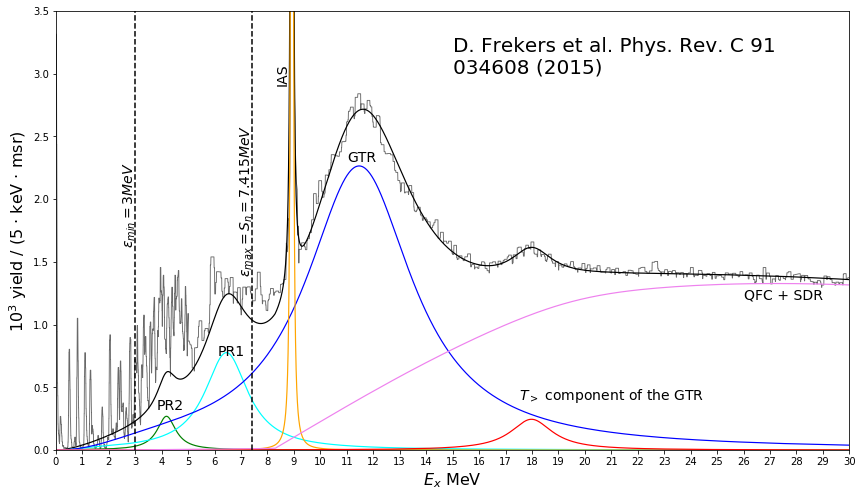

In [19]:
total_mod_comps = total_mod_result.eval_components()

QFCSDR = total_mod_comps['SDR_'] + total_mod_comps['QFC_back_']

plt.figure(figsize=(12,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data4['x'].values, data4['y'].values, 'dimgrey', linewidth=0.9, label='Experimental data \nD. Frekers et al. PHYSICAL REVIEW C 91, 034608 (2015)')
plt.plot(data3['x'].values, total_mod_result.best_fit, 'k', ls='-', label='Total fit',  linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'green', label='PR2', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='PR1', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'blue', label='GTR', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'orange', label='IAS ', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['T1_'], 'red', label='$T_{>}$ component of the GTR', ls='-', linewidth=1.2)
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'y', label='SDR', ls='-', linewidth=1.2)
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, QFCSDR, 'violet', label='QFC + SDR', ls='-', linewidth=1.2)

plt.text(11, 2.3, 'GTR',  fontsize=14)
plt.text(26, 1.2, 'QFC + SDR',  fontsize=14)
plt.text(17.5, 0.4, '$T_{>}$ component of the GTR',  fontsize=14)
plt.text(8.3, 3.0, 'IAS',  fontsize=14, rotation=90)
plt.text(6.1, 0.75, 'PR1',  fontsize=14)
plt.text(3.8, 0.32, 'PR2',  fontsize=14)
plt.text(15, 3, 'D. Frekers et al. Phys. Rev. C 91\n034608 (2015)',  fontsize=20)

S_n = 7.415
plt.axvline(3, c='black', ls='--',)
plt.axvline(S_n, c='black', ls='--',)
plt.text(2.5, 2.2, '$\epsilon_{min}=3 MeV$', rotation=90, fontsize=14)
plt.text(S_n-0.5, 2.5, '$\epsilon_{max}=S_{n}=7.415 MeV$', rotation=90, fontsize=14)

#plt.legend()
plt.xlabel('$E_{x}$ MeV', fontsize=16)
plt.ylabel('$10^{3}$ yield / (5 $\cdot$ keV $\cdot$ msr)', fontsize=16)
plt.xticks(np.arange(0, 31, step=1))
plt.tight_layout()
plt.ylim(0,3.5)
plt.xlim(0,30)
#plt.savefig('ga_decomposition.png', format='png', dpi=500)

(0, 30)

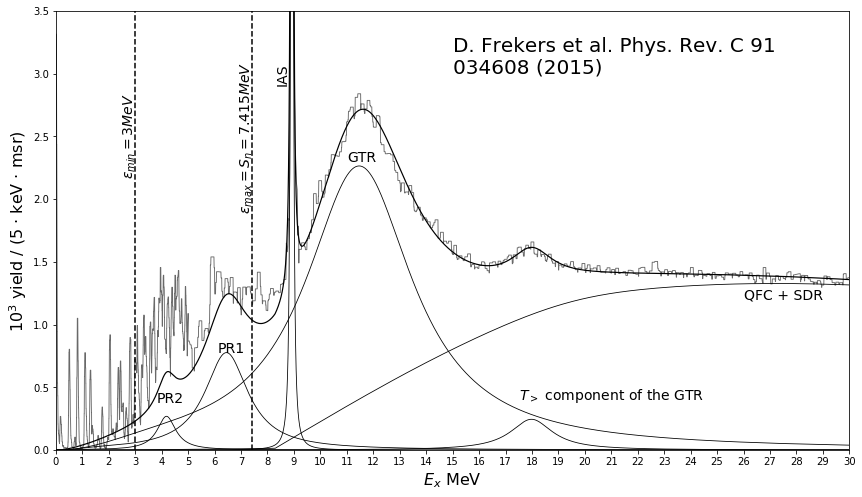

In [20]:
total_mod_comps = total_mod_result.eval_components()

QFCSDR = total_mod_comps['SDR_'] + total_mod_comps['QFC_back_']

plt.figure(figsize=(12,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data4['x'].values, data4['y'].values, 'dimgrey', linewidth=0.9, label='Experimental data \nD. Frekers et al. PHYSICAL REVIEW C 91, 034608 (2015)')
plt.plot(data3['x'].values, total_mod_result.best_fit, 'k', ls='-', label='Total fit',  linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'k', label='PR2', ls='-', linewidth=0.8)
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'k', label='PR1', ls='-', linewidth=0.8)
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'k', label='GTR', ls='-', linewidth=0.8)
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'k', label='IAS ', ls='-', linewidth=0.8)
plt.plot(data3['x'].values, total_mod_comps['T1_'], 'k', label='$T_{>}$ component of the GTR', ls='-', linewidth=0.8)
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'y', label='SDR', ls='-', linewidth=1.2)
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, QFCSDR, 'k', label='QFC + SDR', ls='-', linewidth=0.8)

plt.text(11, 2.3, 'GTR',  fontsize=14)
plt.text(26, 1.2, 'QFC + SDR',  fontsize=14)
plt.text(17.5, 0.4, '$T_{>}$ component of the GTR',  fontsize=14)
plt.text(8.3, 3.0, 'IAS',  fontsize=14, rotation=90)
plt.text(6.1, 0.78, 'PR1',  fontsize=14)
plt.text(3.8, 0.38, 'PR2',  fontsize=14)
plt.text(15, 3, 'D. Frekers et al. Phys. Rev. C 91\n034608 (2015)',  fontsize=20)

S_n = 7.415
plt.axvline(3, c='black', ls='--',)
plt.axvline(S_n, c='black', ls='--',)
plt.text(2.5, 2.75, '$\epsilon_{min}=3 MeV$', rotation=90, fontsize=14)
plt.text(S_n-0.5, 3.0, '$\epsilon_{max}=S_{n}=7.415 MeV$', rotation=90, fontsize=14)

#plt.legend()
plt.xlabel('$E_{x}$ MeV', fontsize=16)
plt.ylabel('$10^{3}$ yield / (5 $\cdot$ keV $\cdot$ msr)', fontsize=16)
plt.xticks(np.arange(0, 31, step=1))
plt.tight_layout()
plt.ylim(0,3.5)
plt.xlim(0,30)
#plt.savefig('ga_decomposition.png', format='png', dpi=500)

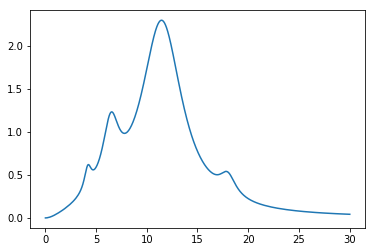

In [21]:
output = pd.DataFrame(data={'x':data3['x'].values, 'y':total_mod_comps['pigmy1_']+
                           total_mod_comps['pigmy2_']+total_mod_comps['GTR_']+
                           total_mod_comps['T1_']})

plt.plot(output['x'].values, output['y'].values)
plt.show()

In [22]:
#output.to_csv('71Ga_2PR.csv')

### theoretical matrix elements

In [23]:
matrix_elems = pd.read_excel('71Ga_matrix_elems_fromLutost.xls')
matrix_elems.head()

,Ex,M^2
0,0.065,0.270
1,0.175,0.006
2,0.990,0.007
3,1.300,0.009
4,1.620,0.006


In [24]:
Ex = np.arange(0,20,0.01)
w = matrix_elems['Ex'].values
M_square = matrix_elems['M^2'].values
alpha = 0.018


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

In [25]:
Ex.shape

(2000,)

In [26]:
plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values

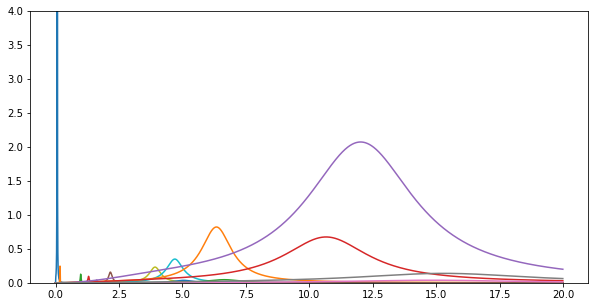

In [27]:
plt.figure(figsize=(10,5))
plt.ylim(0,4)
for y in plots:
    plt.plot(Ex, y)
plt.show()

In [28]:
for plot, M in zip(plots, M_square):
    print(trapz(plot, Ex), M)



0.27002870000000007 0.27
0.005995799999999998 0.006
0.006989700000000003 0.006999999999999999
0.008986600000000006 0.009000000000000001
0.005987399999999999 0.006
0.040999400000000005 0.040999999999999995
0.005984 0.006
0.005984199999999999 0.006
0.19499935 0.195
0.4199982 0.42
0.05000125 0.05
1.7600031999999999 1.76
0.10700180000000001 0.107
3.7200032 3.72
13.800000500000001 13.8
0.0059988 0.006
0.32199955 0.322
1.2000003500000003 1.2


In [29]:
output = pd.DataFrame(data={'Ex':Ex, 'y':np.sum(plots, axis=0)})
output.to_excel('71Ga_theorS(E).xls')

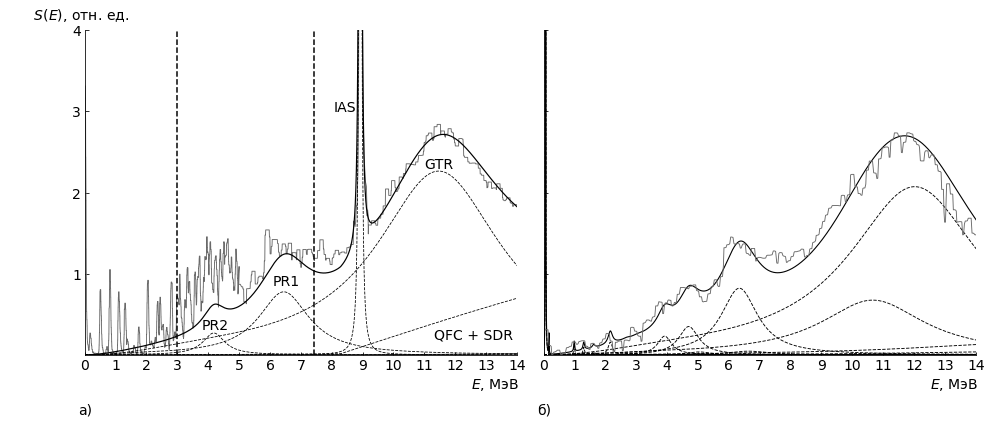

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14,6))

ax1.plot(data4['x'].values, data4['y'].values, 'dimgrey', linewidth=0.9, label='Experimental data \nD. Frekers et al. PHYSICAL REVIEW C 91, 034608 (2015)')
ax1.plot(data3['x'].values, total_mod_result.best_fit, 'k', ls='-', label='Total fit',  linewidth=1.2)
ax1.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'k', label='PR2', ls='--', linewidth=0.8)
ax1.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'k', label='PR1', ls='--', linewidth=0.8)
ax1.plot(data3['x'].values, total_mod_comps['GTR_'], 'k', label='GTR', ls='--', linewidth=0.8)
ax1.plot(data3['x'].values, total_mod_comps['IAS1_'], 'k', label='IAS ', ls='--', linewidth=0.8)
ax1.plot(data3['x'].values, total_mod_comps['T1_'], 'k', label='$T_{>}$ component of the GTR', ls='-', linewidth=0.8)
#ax1.plot(data3['x'].values, total_mod_comps['SDR_'], 'y', label='SDR', ls='-', linewidth=1.2)
#ax1.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='-', linewidth=1.2)
ax1.plot(data3['x'].values, QFCSDR, 'k', label='QFC + SDR', ls='--', linewidth=0.8)

ax1.text(11, 2.3, 'GTR',  fontsize=14)
ax1.text(11.3, 0.2, 'QFC + SDR',  fontsize=14)
#ax1.text(17.5, 0.4, '$T_{>}$ component of the GTR',  fontsize=14)
ax1.text(8.05, 3.0, 'IAS',  fontsize=14, rotation=0)
ax1.text(6.1, 0.85, 'PR1',  fontsize=14)
ax1.text(3.8, 0.31, 'PR2',  fontsize=14)
#ax1.text(15, 3, 'D. Frekers et al. Phys. Rev. C 91\n034608 (2015)',  fontsize=20)

S_n = 7.415
ax1.axvline(3, c='black', ls='--',)
ax1.axvline(S_n, c='black', ls='--',)
#ax1.text(2.5, 2.75, '$\epsilon_{min}=3$ МэВ', rotation=90, fontsize=14)
#ax1.text(S_n-0.5, 3.3, '$\epsilon_{max}=S_{n}=7.415$ МэВ', rotation=90, fontsize=14)

ax1.tick_params(direction='in', labelsize=14)
ax1.set_xlim(0,14)
ax1.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
#ax1.set_ylabel('       $S_{\\beta}$', x=0, y=1.02, rotation=0, fontsize=14)
ax1.set_ylabel('      $S(E)$, отн. ед.', x=0, y=1.02, rotation=0, fontsize=14)
ax1.set_xticks(np.arange(0,15))
ax1.set_yticks(ax1.get_xticks()[1:])
ax1.set_title('a)', x=0, y=-0.2, fontsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

summ = np.sum(plots, axis=0)
BGT_1985 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/bgt_table_values/1985.csv', sep='\t', dtype=np.float, decimal=',')
BGT_1985['d_B(GT)'] = BGT_1985['d_B(GT)']

for y in plots:
    ax2.plot(Ex, y, color='black', ls='--', linewidth = 0.9)
ax2.plot(Ex, summ, color='black', linewidth = 1.1)
ax2.plot(BGT_1985['E'].values, BGT_1985['d_B(GT)'].values/95, 'dimgrey', linewidth=0.9)

ax2.tick_params(direction='in', labelsize=14)
ax2.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax2.set_xlim(0,14)
ax2.set_xticks(np.arange(0,15))
ax2.set_title('б)', x=0, y=-0.2, fontsize=14)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.ylim(0,4)

#plt.savefig("decomposition_theor_exp_71Ga_IzvRAS.png", format='png', transparent=False, dpi=500)
plt.show()

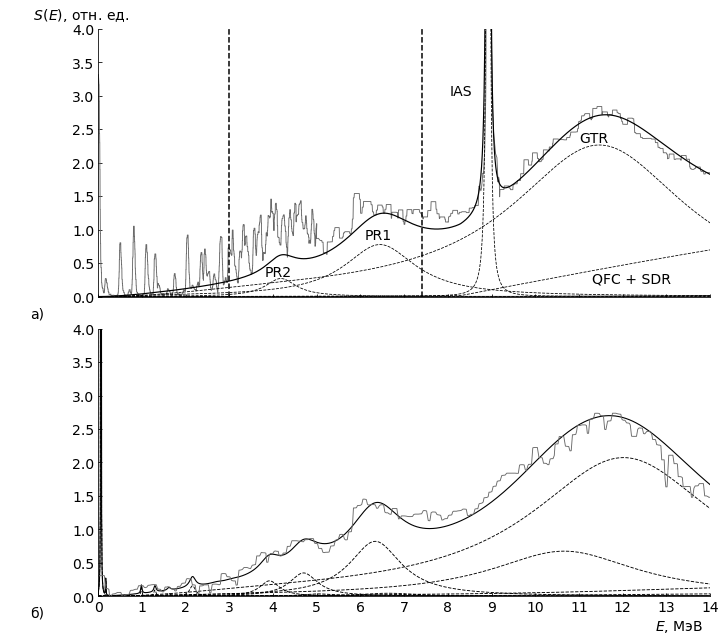

In [45]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(10,9))

ax1.plot(data4['x'].values, data4['y'].values, 'dimgrey', linewidth=0.9, label='Experimental data \nD. Frekers et al. PHYSICAL REVIEW C 91, 034608 (2015)')
ax1.plot(data3['x'].values, total_mod_result.best_fit, 'k', ls='-', label='Total fit',  linewidth=1.2)
ax1.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'k', label='PR2', ls='--', linewidth=0.8)
ax1.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'k', label='PR1', ls='--', linewidth=0.8)
ax1.plot(data3['x'].values, total_mod_comps['GTR_'], 'k', label='GTR', ls='--', linewidth=0.8)
ax1.plot(data3['x'].values, total_mod_comps['IAS1_'], 'k', label='IAS ', ls='--', linewidth=0.8)
ax1.plot(data3['x'].values, total_mod_comps['T1_'], 'k', label='$T_{>}$ component of the GTR', ls='-', linewidth=0.8)
#ax1.plot(data3['x'].values, total_mod_comps['SDR_'], 'y', label='SDR', ls='-', linewidth=1.2)
#ax1.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='-', linewidth=1.2)
ax1.plot(data3['x'].values, QFCSDR, 'k', label='QFC + SDR', ls='--', linewidth=0.8)

ax1.text(11, 2.3, 'GTR',  fontsize=14)
ax1.text(11.3, 0.2, 'QFC + SDR',  fontsize=14)
#ax1.text(17.5, 0.4, '$T_{>}$ component of the GTR',  fontsize=14)
ax1.text(8.05, 3.0, 'IAS',  fontsize=14, rotation=0)
ax1.text(6.1, 0.85, 'PR1',  fontsize=14)
ax1.text(3.8, 0.31, 'PR2',  fontsize=14)
#ax1.text(15, 3, 'D. Frekers et al. Phys. Rev. C 91\n034608 (2015)',  fontsize=20)

S_n = 7.415
ax1.axvline(3, c='black', ls='--',)
ax1.axvline(S_n, c='black', ls='--',)
#ax1.text(2.5, 2.75, '$\epsilon_{min}=3$ МэВ', rotation=90, fontsize=14)
#ax1.text(S_n-0.5, 3.3, '$\epsilon_{max}=S_{n}=7.415$ МэВ', rotation=90, fontsize=14)

ax1.tick_params(direction='in', labelsize=14)
ax1.set_xlim(0,14)
ax1.set_ylim(0,4)
#ax1.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
#ax1.set_ylabel('       $S_{\\beta}$', x=0, y=1.02, rotation=0, fontsize=14)
ax1.set_ylabel('      $S(E)$, отн. ед.', x=0, y=1.02, rotation=0, fontsize=14)
ax1.set_xticks(np.arange(0,15))
#ax1.set_yticks(ax1.get_xticks()[1:])
ax1.set_title('a)', x=-0.1, y=-0.1, fontsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

summ = np.sum(plots, axis=0)
BGT_1985 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/bgt_table_values/1985.csv', sep='\t', dtype=np.float, decimal=',')
BGT_1985['d_B(GT)'] = BGT_1985['d_B(GT)']

for y in plots:
    ax2.plot(Ex, y, color='black', ls='--', linewidth = 0.9)
ax2.plot(Ex, summ, color='black', linewidth = 1.1)
ax2.plot(BGT_1985['E'].values, BGT_1985['d_B(GT)'].values/95, 'dimgrey', linewidth=0.9)

ax2.tick_params(direction='in', labelsize=14)
ax2.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax2.set_xlim(0,14)
ax2.set_xticks(np.arange(0,15))
ax2.set_title('б)', x=-0.1, y=-0.1, fontsize=14)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.ylim(0,4)

plt.savefig("decomposition_theor_exp_71Ga_IzvRAS.png", format='png', transparent=False, dpi=500)
plt.show()